<a href="https://colab.research.google.com/github/Aniruddha-Kulkarni/Media-Memorability/blob/master/Aniruddha_Kulkarni_19210279_MediaPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA684 - Media Memorability Assignment

This task focuses on predicting how well the viewers remember the video or to put it in other way, How memorable the video is to viewers. 

**Problem Statement:** To build a model for predicting/analyzing how memorable is the video by calculating the memorability score (Spearman Coefficient). Here the best model is selected based on the Spearman coefficient rank.

In [1]:
!pip install pyprind



**Importing required Libraries**



In [0]:
import pandas as pd
import numpy as np
import pyprind
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob
import nltk

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684_Assignment')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Section 1: Feature Extraction

In [0]:
#Function to load C3D features
def load_c3d(captions, c3dPath):
    files = list(captions["video"].values)
    c3dfeatures = []
    for file in files:
        file = c3dPath+file[:-4]+'txt'
        c3dfeatures.append(np.loadtxt(file))
    #print(type(c3dfeatures))
    return c3dfeatures

In [0]:
#Function to load HMP features
def load_hmp(captions, hmp_path):
    files = list(captions["video"].values)
    hmp_features = []
    for file in files:
        file = hmp_path+file[:-4]+'txt'
        with open(file) as f:
            for line in f:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                HMP = np.zeros(6075)
            for idx in HMP_temp.keys():
                HMP[idx-1] = HMP_temp[idx]
            hmp_features.append(HMP)
    return hmp_features

In [0]:
#Function to load the captions into dataframes
def load_captions(filename):
    video_name = []
    captions = []
    dataframe = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #each line in the text file contains to words so, this code will split them into two words
            video_name.append(pair[0]) #first word will be assigned as video name
            captions.append(pair[1]) #second word will be assigned as caption
        dataframe['video']=video_name #setting these two as column names of dataframe
        dataframe['caption']=captions
    return dataframe

In [0]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Loading Features from the Dataset

In [0]:
#load the ground truth dataset
csv_path ='/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv'
dataset = pd.read_csv(csv_path)

#load captions
captions_path ='/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
captions = load_captions(captions_path)


#load C3D features
c3dPath = '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/'
c3dfeatures = load_c3d(captions,c3dPath)

#load HMP features
hmp_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/'
hmp_features = load_hmp(captions,hmp_path)

In [10]:
dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [11]:
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [12]:

#shape of the dataframes
print(f'Ground Truth : {dataset.shape}')
print(f'Dev Captions : {captions.shape}')
print(f'C3D          : ({len(c3dfeatures)})')
print(f'HMP          : ({len(hmp_features)})')

Ground Truth : (6000, 5)
Dev Captions : (6000, 2)
C3D          : (6000)
HMP          : (6000)


# Section 2: Data Preprocessing

As seen above,Dev dataset have been loaded. In this section i will implement CountVectorizer. To avoid any mismatch in dimensions, both the caption have been combined of which 6000 will be split for training and 2000 for prediction. 

In [13]:
#loading the nltk stopwords of English

import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopwords)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Length of Stopwords: 179


Below, I will be removing any punctuations or stop words and also convert any upper case letters to lower case to maintain consistency throughout the file.

In [14]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [15]:
captions.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


In [16]:
#implementing CountVectorizer for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_list = vectorizer.fit_transform(captions.caption).toarray()
type(captions_list)

numpy.ndarray

In [17]:
captions_list.shape

(6000, 3112)

* **Import Test Dataset**

Same Data Cleaning has been carried out above for test dataset.

In [0]:
#importing test Dataset
test_captions_path ='/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
test_captions = load_captions(test_captions_path)

In [0]:
csv_path_test ='/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
test_dataset = pd.read_csv(csv_path_test)

In [20]:
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [21]:
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [22]:
#printing the dimensions of test-set dataset and features
print(f'Test-Dataset : {test_dataset.shape}')
print(f'Test-Captions: {test_captions.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


In [23]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(test_captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(test_captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    test_captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [24]:
test_captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


## Section 2.1: Storing a list of captions into a variable

In [25]:
#implementing CountVectorizer for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_captions_list = vectorizer.fit_transform(test_captions.caption).toarray()
type(test_captions_list)

numpy.ndarray

In [26]:
print(f'Development Vocabulary Size   : {len(captions_list[0])}')
print(f'Testing Vocabulary Size       : {len(test_captions_list[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


## Section 2.2 Combining Captions and C3D into a single Vector

In [0]:
c3d_captions = (captions_list.tolist())
counter = 0
for item in range(6000):
    c3d_captions[counter] = np.append(c3d_captions[counter],c3dfeatures[counter],axis=0)
    counter = counter+1

In [28]:
len(c3d_captions[0])

3213

In [29]:
len(c3d_captions)

6000

## Section 2.3: Combining Caption+hmp+C3D

In [0]:
#Combining c3d_captions with HMP to form 
c3d_captions_hmp = c3d_captions
counter = 0
for item in range(6000):
    c3d_captions_hmp[counter] = np.append(c3d_captions_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1

In [31]:
len(c3d_captions_hmp[0])

9288

In [32]:
len(c3d_captions_hmp)

6000

## Section 2.4: Combining Caption and HMP

In [0]:
hmp_captions = (captions_list.tolist())
counter = 0
for item in range(6000):
    hmp_captions[counter] = np.append(hmp_captions[counter],hmp_features[counter],axis=0)
    counter = counter+1

# Section 3: Using Different Models on Dataset

Here, I have used 2 models Random Forest and Decision Tree with different features or combination of features. Out of two models the best one was selected to fit the model in test set.

## Section 3.1: Random Forest Model 



### Section 3.1.1: Random Forest with Captions





In [0]:
X = captions_list
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [36]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)

In [38]:
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
captions_pred = captions_rf.predict(X_test)

In [40]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.409
The Spearman's correlation coefficient is: 0.176




### Section 3.1.2: Random Forest Using C3D and Caption



In [0]:
X = c3d_captions
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [44]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 14.7min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [45]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [46]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.300
The Spearman's correlation coefficient is: 0.120



### Section 3.1.3: Random Forest with C3D, Caption and HMP




In [0]:
X = c3d_captions_hmp
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45,verbose=2)

In [50]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 29.4min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [51]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [52]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.322
The Spearman's correlation coefficient is: 0.145


### Section 3.1.4 Random Forest with HMP

In [0]:
X = hmp_features
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [56]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [57]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [58]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.287
The Spearman's correlation coefficient is: 0.140


### Section 3.1.5: Random Forest with Captions and HMP

In [0]:
X = hmp_captions
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [62]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 12.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [63]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [64]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.304
The Spearman's correlation coefficient is: 0.109



## Section 3.2: Decision Tree Model



### Section 3.2.1: Decision Tree with Captions

In [0]:
X = captions_list
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [67]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [68]:
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.223
The Spearman's correlation coefficient is: 0.054


### Section 3.2.2: Decision Tree with Captions and C3D

In [0]:
X = c3d_captions
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [71]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [72]:
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.035
The Spearman's correlation coefficient is: -0.017


### Section 3.2.3: Decision Tree with Captions,C3D and HMP

In [0]:
X = c3d_captions_hmp
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [75]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [76]:
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.102
The Spearman's correlation coefficient is: 0.030


### Section 3.2.4: Decision Tree with HMP

In [0]:
X = hmp_features
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [79]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [80]:
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.122
The Spearman's correlation coefficient is: 0.008


### Section 3.2.5: Decision Tree with HMP and Caption

In [0]:
X = hmp_captions
y = dataset[['short-term_memorability','long-term_memorability']].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [83]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [84]:
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.083
The Spearman's correlation coefficient is: -0.015


# Section 4: Comparison of Two Models

Below is the table of comparison for Two models RF and DT with their Spearman Coefficient Ranks. We can see that Random Forest has good ranking as compared to Decision Tree. Therefore, I will consider Random Forest model for predicting test data.

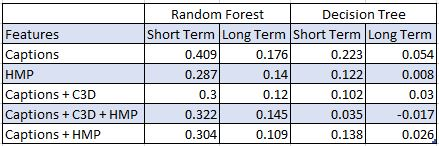

In [85]:
from IPython.display import Image
Image(filename="/content/Table1.JPG",width="700",height="250")

# Section 5: Training and Predicting the model

Now for here we will train the model on complete Dev dataset which has 6000 record. Later I will predict the scores on 2000 data from test dataset.

In [0]:
X = captions_list
y = dataset[['short-term_memorability','long-term_memorability']].values

In [87]:
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45)

In [89]:
rf_regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

## Section 5.1: Predicting the test Dataset

In [0]:
#Predicting the test dataset

test_pred = rf_regressor.predict(test_captions_list)

In [0]:

pred = pd.DataFrame()

In [92]:
type(test_pred)

numpy.ndarray

In [0]:
pred['short-term'] = test_pred[:,0]

In [0]:
pred['long-term'] = test_pred[:,1]

In [95]:
pred.head()

,short-term,long-term
0,0.854635,0.712699
1,0.898883,0.781500
2,0.841901,0.805625
3,0.915282,0.826990
4,0.866134,0.711727


In [96]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.848028,0.751163
std,0.034564,0.067863
min,0.687093,0.397318
25%,0.830368,0.721224
50%,0.849698,0.757218
75%,0.871004,0.792872
max,0.953749,0.949478


In [0]:
pred.to_csv("/content/drive/My Drive/Ani_ML_Results/Aniruddha_Kulkarni_19210279_Results.csv",index=False)